<a href="https://colab.research.google.com/github/aaolcay/Traditional-Machine-Learning-Techniques/blob/main/Logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Logistic Regression (Binary Classification)**
In this Python notebook, we write a Neural Netwoek algorithm from the scratch as one can understand how the gradient descent is used to update the weights and bias terms to minimize cost function. Thus, the accuracy of the model in prediction enhances.

We will use logistic regression in this application for image classification and the data were taken from [Kaggle](https://www.kaggle.com/datasets/chetankv/dogs-cats-images). The data consists of many images of dogs and cats, but we use only some of the cat and dog images. Logistic regression, therefore, estimates the probability of an image being a cat (1) or a dog (0).

In [1]:
import os

**Authenticate Drive Account**

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


**Download Kaggle Dataset**

In [3]:
# Install kaggle python library
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Note that you need to create `New API Token` from your `Kaggle` account and upload it into a folder created for the data. In this example, I put downloaded `json` file into a folder called `Data`. 

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = '/gdrive/MyDrive/Logistic Regression as a Neural Network/Data'

In [5]:
# changing the working directory
%cd '/gdrive/MyDrive/Logistic Regression as a Neural Network/Data'

/gdrive/MyDrive/Logistic Regression as a Neural Network/Data


In [6]:
# checking the current working directory
!pwd

/gdrive/MyDrive/Logistic Regression as a Neural Network/Data


Open Kaggle link in which the dataset was located, `Copy API command` and paste the cell below after `!`

In [ ]:
!kaggle datasets download -d chetankv/dogs-cats-images

In [ ]:
!unzip \*.zip && rm *.zip

#### **Load Data**
After uploading the images from Kaggle, we can build our dataset with cat and dog images.

**Cat Images**

In [147]:
from PIL import Image
import numpy as np
# Load some cat images
cat = []
for i in range(4001,4115):
  a = str(i)
  file_name = '/gdrive/MyDrive/Logistic Regression as a Neural Network/Data/dataset/test_set/cats/cat.'+ a +'.jpg'
  image = Image.open(file_name)
  image = image.resize((160,120))
  image = np.array(image)
  cat.append(image)

In [148]:
cat_data = np.array(cat).astype("uint8") 
cat_data = (cat_data-np.min(cat_data))/(np.max(cat_data)-np.min(cat_data))

In [149]:
cat_data.shape

(114, 120, 160, 3)

**Dog Images**

In [150]:
dog = []
for i in range(4001,4115):
  a = str(i)
  file_name = '/gdrive/MyDrive/Logistic Regression as a Neural Network/Data/dataset/test_set/dogs/dog.'+ a +'.jpg'
  image = Image.open(file_name)
  image = image.resize((160,120))
  image = np.array(image)
  dog.append(image)

In [151]:
dog_data = np.array(dog).astype("uint8") 
dog_data = (dog_data-np.min(dog_data))/(np.max(dog_data)-np.min(dog_data))

In [152]:
dog_data.shape

(114, 120, 160, 3)

Text(0.5, 1.0, 'Cat')

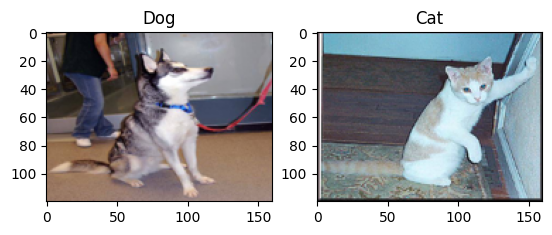

In [153]:
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1,2,1)
plt.imshow(dog_data[0])
plt.title('Dog')
plt.subplot(1,2,2)
plt.imshow(cat_data[0])
plt.title('Cat')

**Build the Labels and Concatenate all the Images**

In [154]:
cat_data_labels=np.ones((cat_data.shape[0],1),dtype='float')

In [155]:
dog_data_labels=np.zeros((dog_data.shape[0],1),dtype='float')

In [156]:
dataset = np.concatenate((cat_data,dog_data), axis=0)
dataset_labels = np.concatenate((cat_data_labels,dog_data_labels), axis=0)

**Shuffle the Dataset**

In [157]:
idx = np.random.permutation(len(dataset))
dataset, dataset_labels = dataset[idx], dataset_labels[idx]

**See Shuffled Dataset**

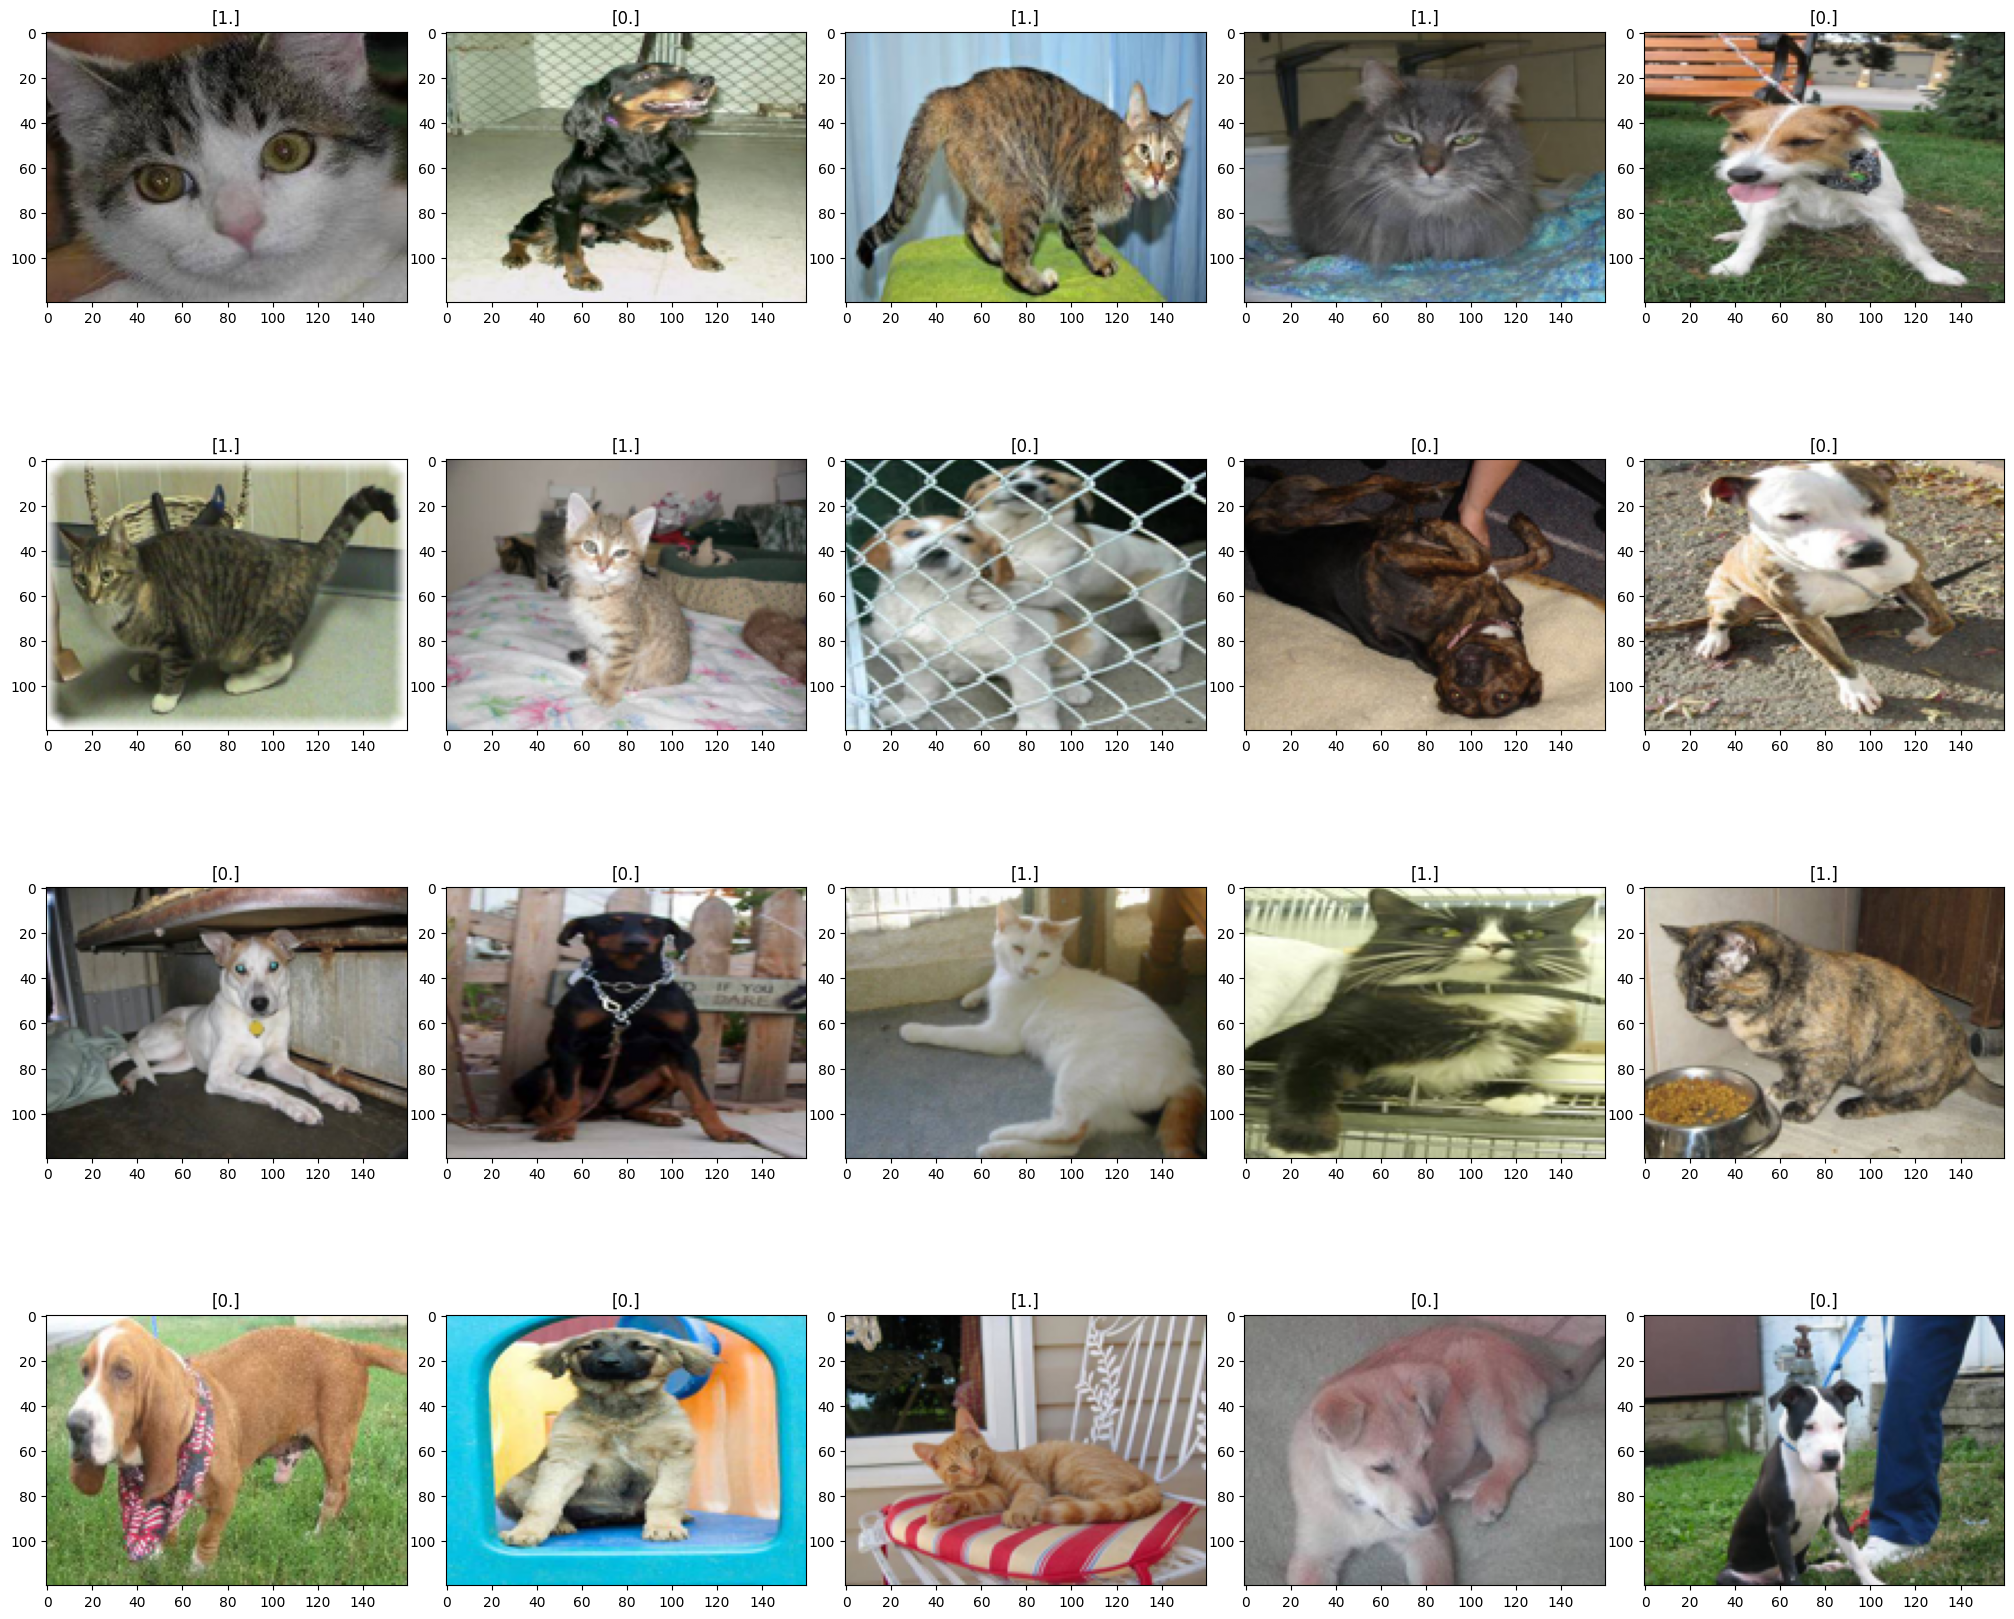

In [158]:
fig = plt.figure(figsize=(20,20))
for i in range(20):
  fig.add_subplot(4,5,i+1)
  plt.imshow(dataset[i,:,:,:])
  plt.title(f'{dataset_labels[i,:]}')
  fig.tight_layout(pad=0.2)

**Split Dataset into Test and Train**

In [159]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, dataset_labels, test_size=0.3, random_state=42)

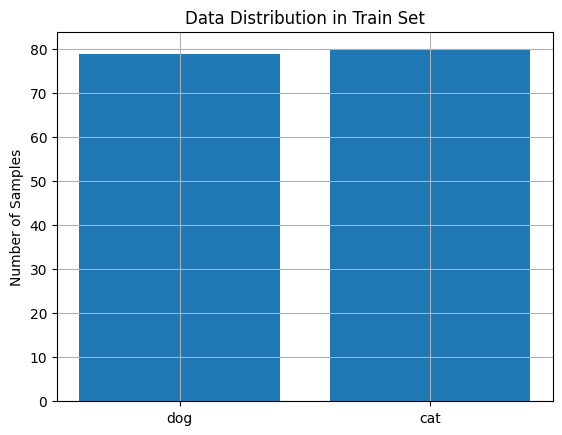

In [160]:
num_class = np.zeros(2)
num_class[0] =len(np.where(y_train==0.)[0])
num_class[1] =len(np.where(y_train==1.)[0])
labels_class = ['dog', 'cat']
plt.figure()
plt.bar(labels_class,num_class)
plt.ylabel('Number of Samples')
plt.title('Data Distribution in Train Set')
plt.grid()

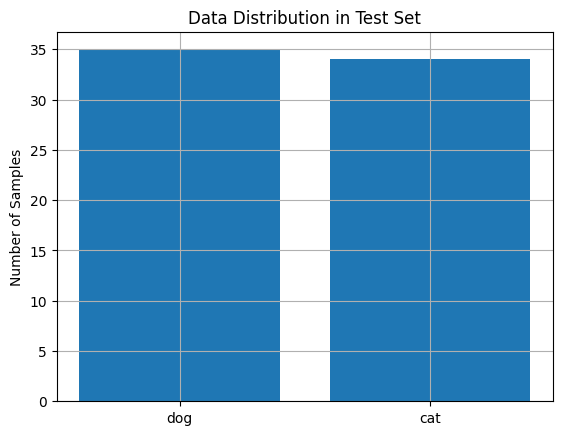

In [161]:
num_class_test = np.zeros(2)
num_class_test[0] =len(np.where(y_test==0.)[0])
num_class_test[1] =len(np.where(y_test==1.)[0])
plt.figure()
plt.bar(labels_class,num_class_test)
plt.ylabel('Number of Samples')
plt.title('Data Distribution in Test Set')
plt.grid()

####**Logistic Regression**
We use logistic regression, so we need to convert these three channel images (120,160,3) the vectors of (120x160x3=57600,1).
We have 159 training and 69 test data, so the shapes will be:

`X_train` -> (159, 57600)

`X_test` -> (69, 57600)


In [162]:
train_vector = []
for i in range(X_train.shape[0]):
  train = X_train[i,:,:,:].reshape(-1,1)
  train_vector.append(train)
X_train = np.array(train_vector)

In [163]:
test_vector = []
for i in range(X_test.shape[0]):
  test = X_test[i,:,:,:].reshape(-1,1)
  test_vector.append(test)
X_test = np.array(test_vector)

In [164]:
X_train = np.squeeze(X_train)
X_train = X_train.T
X_test = np.squeeze(X_test)
X_test = X_test.T
y_test = y_test.T
y_train = y_train.T

#####**Create Logistic Regression Model**

In [193]:
import copy
def propagate(w, b, X, Y):
  m = X.shape[1]
  A = 1/(1+np.exp(-(np.dot(w.T,X)+b)))
  cost = -(1/m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))
  dw = (1/m)*np.dot(X,(A-Y).T)
  db = (1/m)*np.sum(A-Y)

  grads = {"dw": dw,"db": db}
  return grads, cost

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
  w = copy.deepcopy(w)
  b = copy.deepcopy(b)
  costs = []  
  for i in range(num_iterations):
    grads,cost = propagate(w, b, X, Y)
    dw = grads["dw"]
    db = grads["db"]
    w -= learning_rate*dw
    b -= learning_rate*db
    if i % 100 == 0:
      costs.append(cost)
      if print_cost:
        print ("Cost after iteration %i: %f" %(i, cost))
  
  params = {"w": w, "b": b}
  grads = {"dw": dw,"db": db}
  
  return params, grads, costs

def predict(w, b, X):  
  m = X.shape[1]
  Y_prediction = np.zeros((1, m))
  w = w.reshape(X.shape[0], 1)
  A = 1/(1+np.exp(-(np.dot(w.T,X)+b)))
  for i in range(A.shape[1]):
    if A[0,i]>0.5:
      Y_prediction[0,i] = 1.
    else:
      Y_prediction[0,i] = 0.
    return Y_prediction

def logistic_regression_model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, print_cost=False):
    # initialize parameters with zeros 
    # w, b = ...
    dim = X_train.shape[0]
    w = np.zeros((dim,1))
    b = 0.
    # Gradient descent 
    # params, grads, costs = ...
    params, grads, costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate, print_cost=print_cost)
    # Retrieve parameters w and b from dictionary "params"
    # w = ...
    # b = ...
    w = params['w']
    b = params['b']
    # Predict test/train set examples
    # Y_prediction_test = ...
    # Y_prediction_train = ...
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [194]:
d=logistic_regression_model(X_train, y_train, X_test, y_test, num_iterations=50000, learning_rate=0.001, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.986005
Cost after iteration 200: 0.727410
Cost after iteration 300: 0.508010
Cost after iteration 400: 0.337214
Cost after iteration 500: 0.263903
Cost after iteration 600: 0.238690
Cost after iteration 700: 0.217750
Cost after iteration 800: 0.199995
Cost after iteration 900: 0.184745
Cost after iteration 1000: 0.171514
Cost after iteration 1100: 0.159936
Cost after iteration 1200: 0.149727
Cost after iteration 1300: 0.140666
Cost after iteration 1400: 0.132574
Cost after iteration 1500: 0.125311
Cost after iteration 1600: 0.118757
Cost after iteration 1700: 0.112818
Cost after iteration 1800: 0.107414
Cost after iteration 1900: 0.102477
Cost after iteration 2000: 0.097951
Cost after iteration 2100: 0.093789
Cost after iteration 2200: 0.089950
Cost after iteration 2300: 0.086398
Cost after iteration 2400: 0.083104
Cost after iteration 2500: 0.080041
Cost after iteration 2600: 0.077186
Cost after iteration 2700: 0.074519
Cost

In [195]:
cost=d["costs"]

Text(0, 0.5, 'Cost Function (J(w,b))')

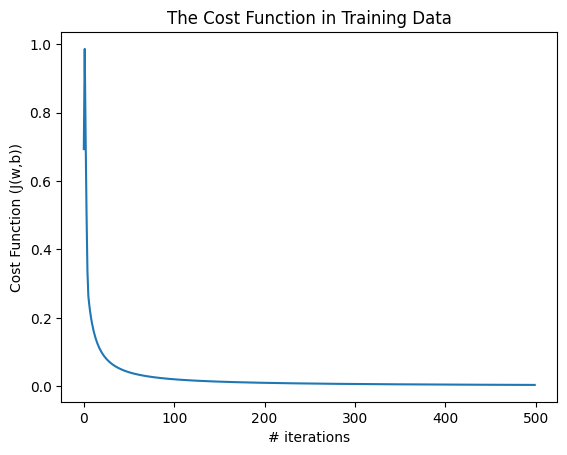

In [196]:
plt.figure()
plt.plot(cost)
plt.title('The Cost Function in Training Data')
plt.xlabel('# iterations')
plt.ylabel('Cost Function (J(w,b))')

**Discussion**
As seen, accuracies are really low, this can stem from both number of data and data examples (cats and dogs images but we vectorized them). However, the cost (error) reduces over the iterations. One can try to use logistic regression (binary classification) with only cat or dog images to predict whether or not the input image is a cat (or the same process for dog images).

Please contact me and share your views and suggestions.

olcayazzam@gmail.com